# Practicing PCA on a Face Dataset


## Packages


In [3]:
# loading need libraries
import numpy as np
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
from scipy.linalg import svd

## Explore Dataset characteristics

In [4]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=1)
n_samples, image_height, image_width = lfw_people.images.shape

X = lfw_people.data

# the label to predict is the id of the person
Y = lfw_people.target
Y_names = lfw_people.target_names
n_classes = Y_names.shape[0]

print("Dataset properties:")
print("\t Number of data points: %d" % X.shape[0])
print("\t Number of features: %d" % X.shape[1])
print("\t Number of classes: %d" % n_classes)
print("\t Width of each image: %d" % image_width)
print("\t Height of each image: %d" % image_height)

Dataset properties:
	 Number of data points: 1288
	 Number of features: 11750
	 Number of classes: 7
	 Width of each image: 94
	 Height of each image: 125


## Showing the pictures

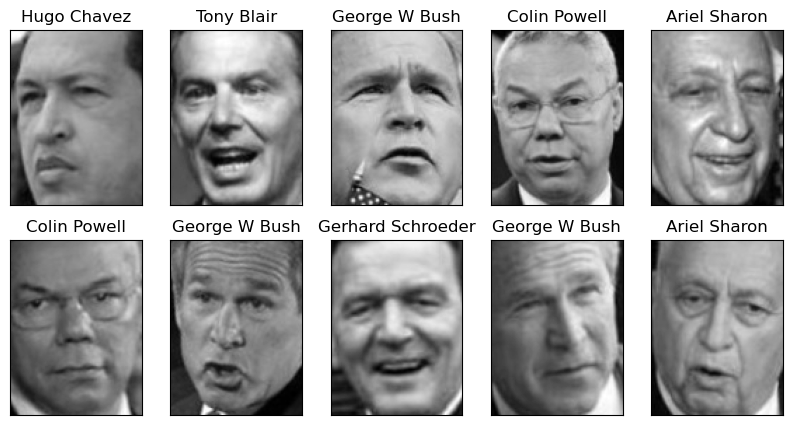

In [5]:
def plot_faces(images, labels, names, n_row, n_col):
    """Helper function to plot a gallery of portraits"""
    f = plt.figure(figsize=(10,5))
    for i in range(n_row * n_col):
        subfigure = f.add_subplot(n_row, n_col, i + 1)
        subfigure.imshow(images[i].reshape((image_height, image_width)), cmap=plt.cm.gray)
        subfigure.set_title(names[labels[i]])
        # Removing the axes
        plt.xticks(())
        plt.yticks(())
    plt.show()


plot_faces(X, Y, Y_names, 2, 5)

## Select "Colin Powell" class

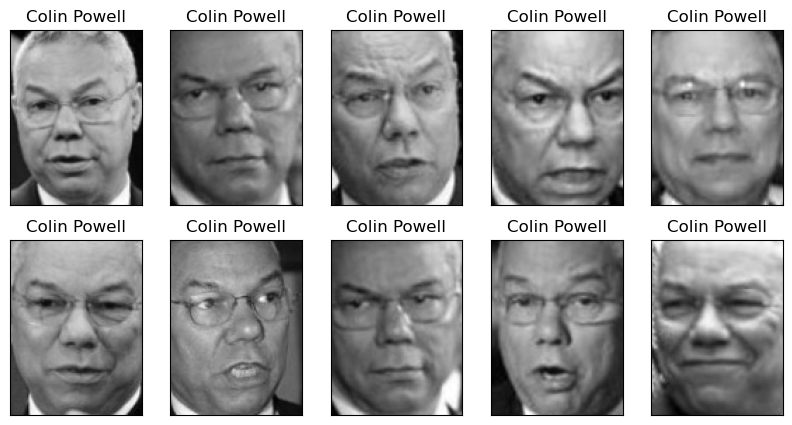

In [6]:
class_name = 'Colin Powell'
class_indx = list(Y_names).index(class_name)

X = X[Y==class_indx,:]
Y = Y[Y==class_indx]

plot_faces(X, Y, Y_names, 2, 5)

## Eigenfaces

* The below code is supposed to generate the "average faces" as well as the first "eigen faces" for Colin Powell class. 

* [Relationship between PCA and SVD](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca)

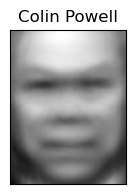

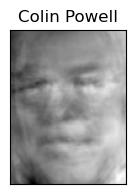

In [7]:
def centeralize_data(images):
    
    # Subtract the data mean from datapoints.
    # Return centeralized data and data mean

    # make a copy of images so that X will not be modified
    imagesCopy = np.copy(images)

    # assume the matrix is n by d
    n = imagesCopy.shape[0] ; d = imagesCopy.shape[1]

    # get data mean
    sum = 0;
    for i in range(n):
        sum += imagesCopy[i , :]
    data_mean = sum / n;

    # get centralized data
    for i in range(n):
        imagesCopy[i,:] -= data_mean
    c_data = imagesCopy

    return c_data , data_mean

def normalized_svd(images):
    XN, data_mean = centeralize_data(images)
    U,S,Vt = svd(XN)
    return U,S,Vt,data_mean

def pca_components(Vt, n_components):
    # Return first n components (first n principal direction/axes)

    # calculate V
    V = np.transpose(Vt)

    # calculate size of components and initialize components
    SIZE = (n_components, V.shape[0])
    components = np.zeros(SIZE)

    for i in range(n_components):
        components[i,:] = np.transpose(V[:,i])

    return components


def average_image_class(images):
    class_average = np.mean(images, axis = 0)
    return class_average

def eigen_face_class(images):
    _,_,Vt,_ = normalized_svd(images)
    return pca_components(Vt, n_components=1)

def plot_class_representatives(images, class_name, aggregator):
    f = plt.figure(figsize=(2,2))
    subfigure = f.add_subplot(1,1,1)
    class_representative = aggregator(images)

    subfigure.imshow(class_representative.reshape((image_height, image_width)), cmap=plt.cm.gray)
    subfigure.set_title(class_name)
    # Removing the axes
    plt.xticks(())
    plt.yticks(())
    plt.show()


plot_class_representatives(X, class_name, aggregator=average_image_class)
plot_class_representatives(X, class_name, aggregator=eigen_face_class)

## PCA visualization

Project the data into the 2D plane to be able to visualize

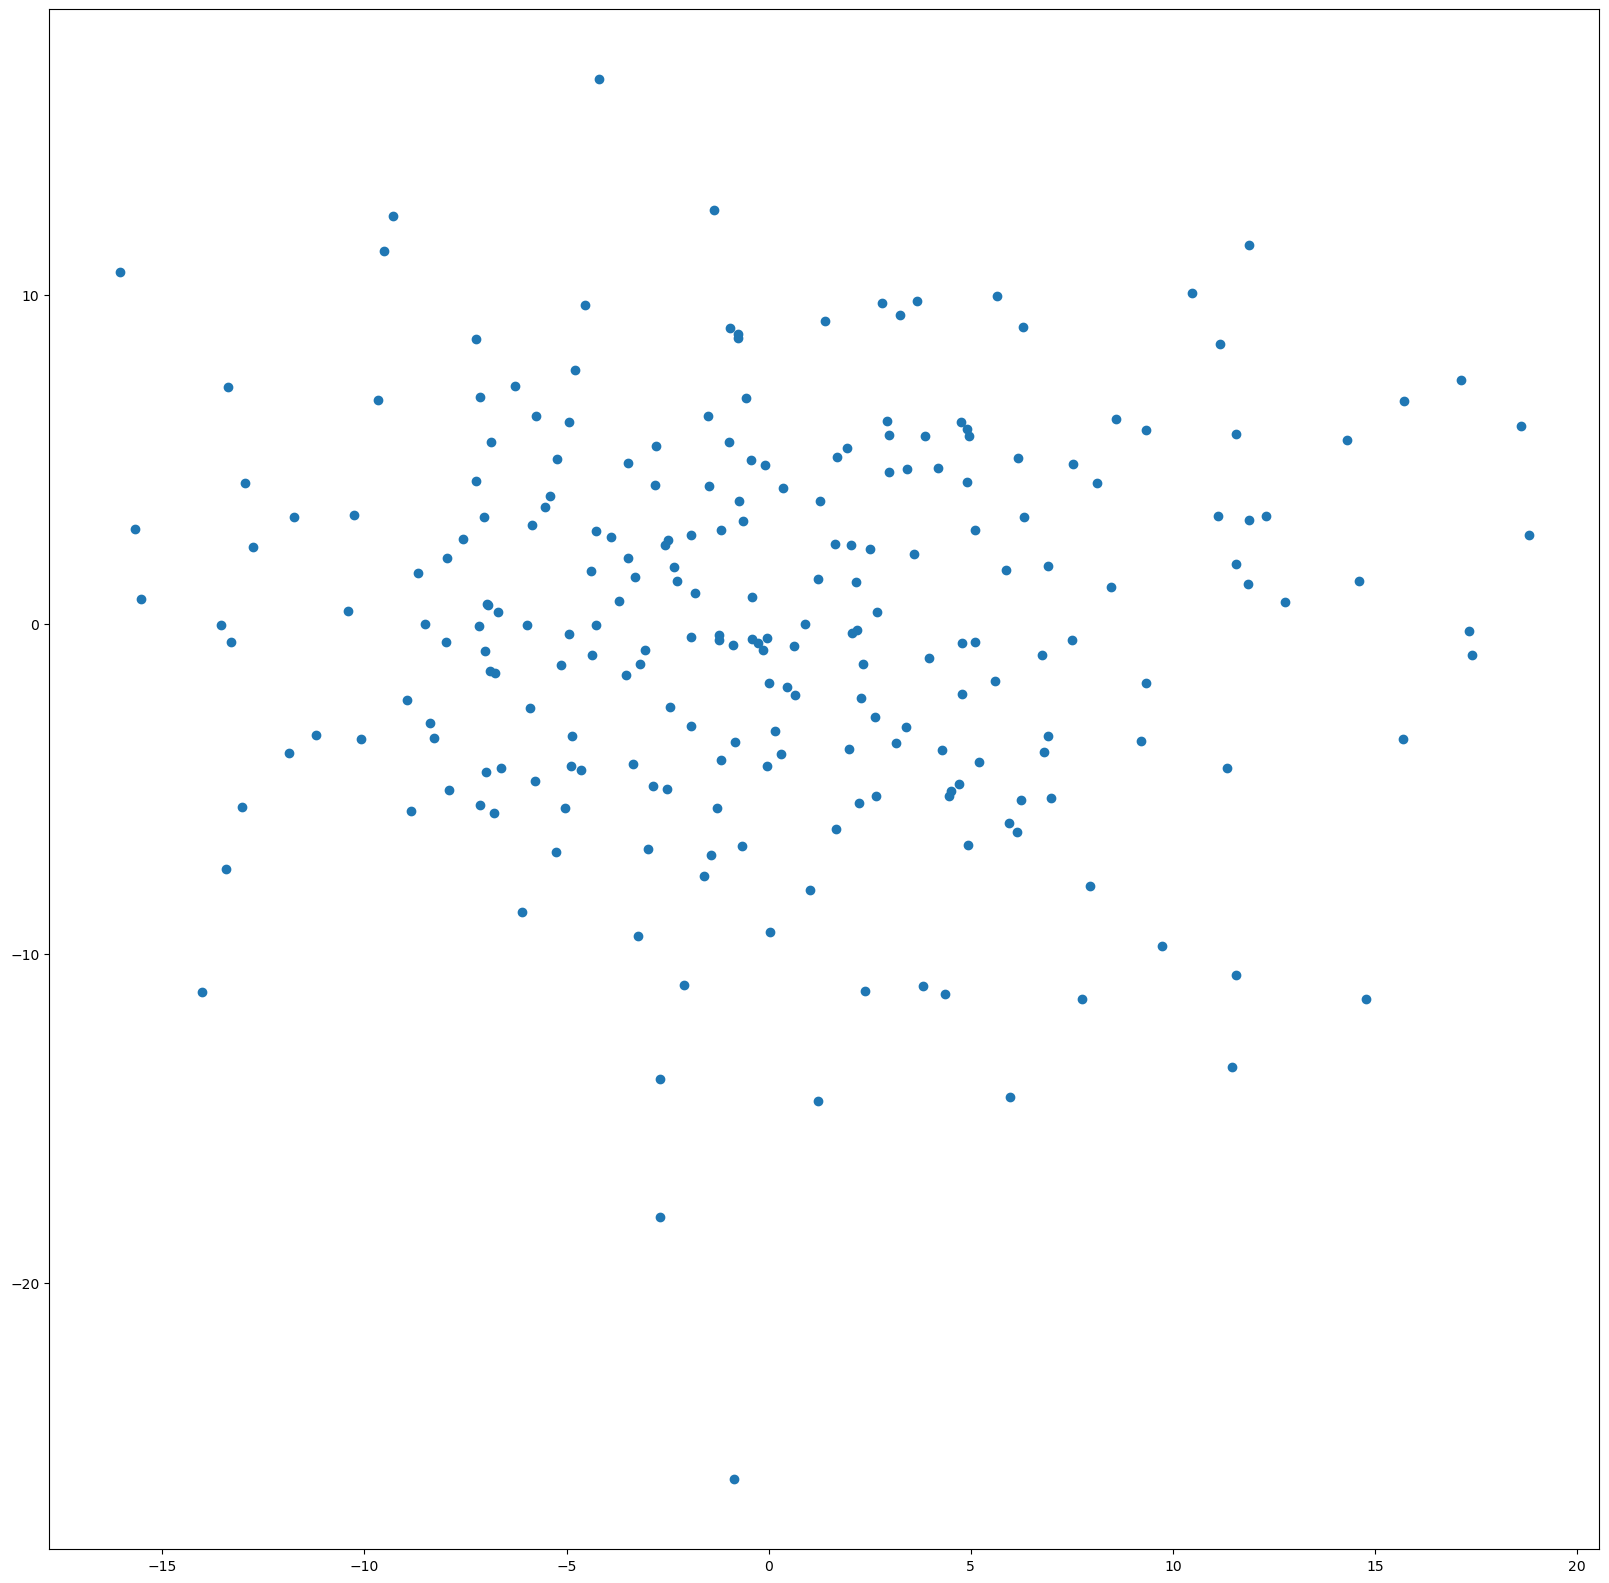

In [8]:
def pca_transform(U,S, n_components):

    US = np.matmul(U, np.diag(S))
    SIZE = (US.shape[0], n_components)
    transformed_data = np.zeros(SIZE)

    for i in range(n_components):
        transformed_data[:,i] = US[:,i]

    return transformed_data

U,S,Vt,data_mean = normalized_svd(X)
T = pca_transform(U,S, n_components=2)
fig = plt.figure(figsize=(20,20))
plt.plot(T[:, 0], T[:, 1], 'o')

## Reconstructing images

1. Use the PCA (applied to the whole data set) to reduce the dimensionality of the data points to 2
2. Then, transform the 2D data points back to the original space to reconstruct the images

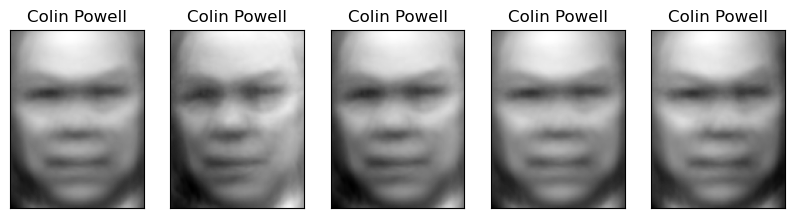

In [9]:
def pca_inverse_transform(transformed_data, components, data_mean):

    dataNumber = transformed_data.shape[0]

    reconstructed_data = np.matmul(transformed_data, components)
    for i in range(dataNumber):
        reconstructed_data[i,:] += data_mean
    return reconstructed_data


plot_faces(pca_inverse_transform(T, Vt[:2,:], data_mean),Y, Y_names, 1, 5)

## Average Reconstruction Error
Separate the image dataset into train (100 images) and test (rest of the data) datasets.
Train PCA with [2, 5, 20, 40, 70, 100] components respectively. Reconstruction error is defined as $error=(\sum_{i=1}^n||x_i-reconstruct(pca(x_i))||^2_2)/n$.

Plot average reconstruction error on training and testing data points with the following requirements:
  1. X-axis shows number of components.
  2. Y-axis shows reconstruction error.
  3. Draw two graphs, one for training and the other line for testing.



Training Set Error =  [147.2162801985788, 103.50111848620013, 47.94730163413059, 22.863408148549592, 6.323235953185748, 4.725169458488847e-10]
Testing  Set Error =  [175.11497751268143, 133.74993301093124, 91.83337382130253, 76.78518283052165, 66.13130364678713, 60.17700609366819]






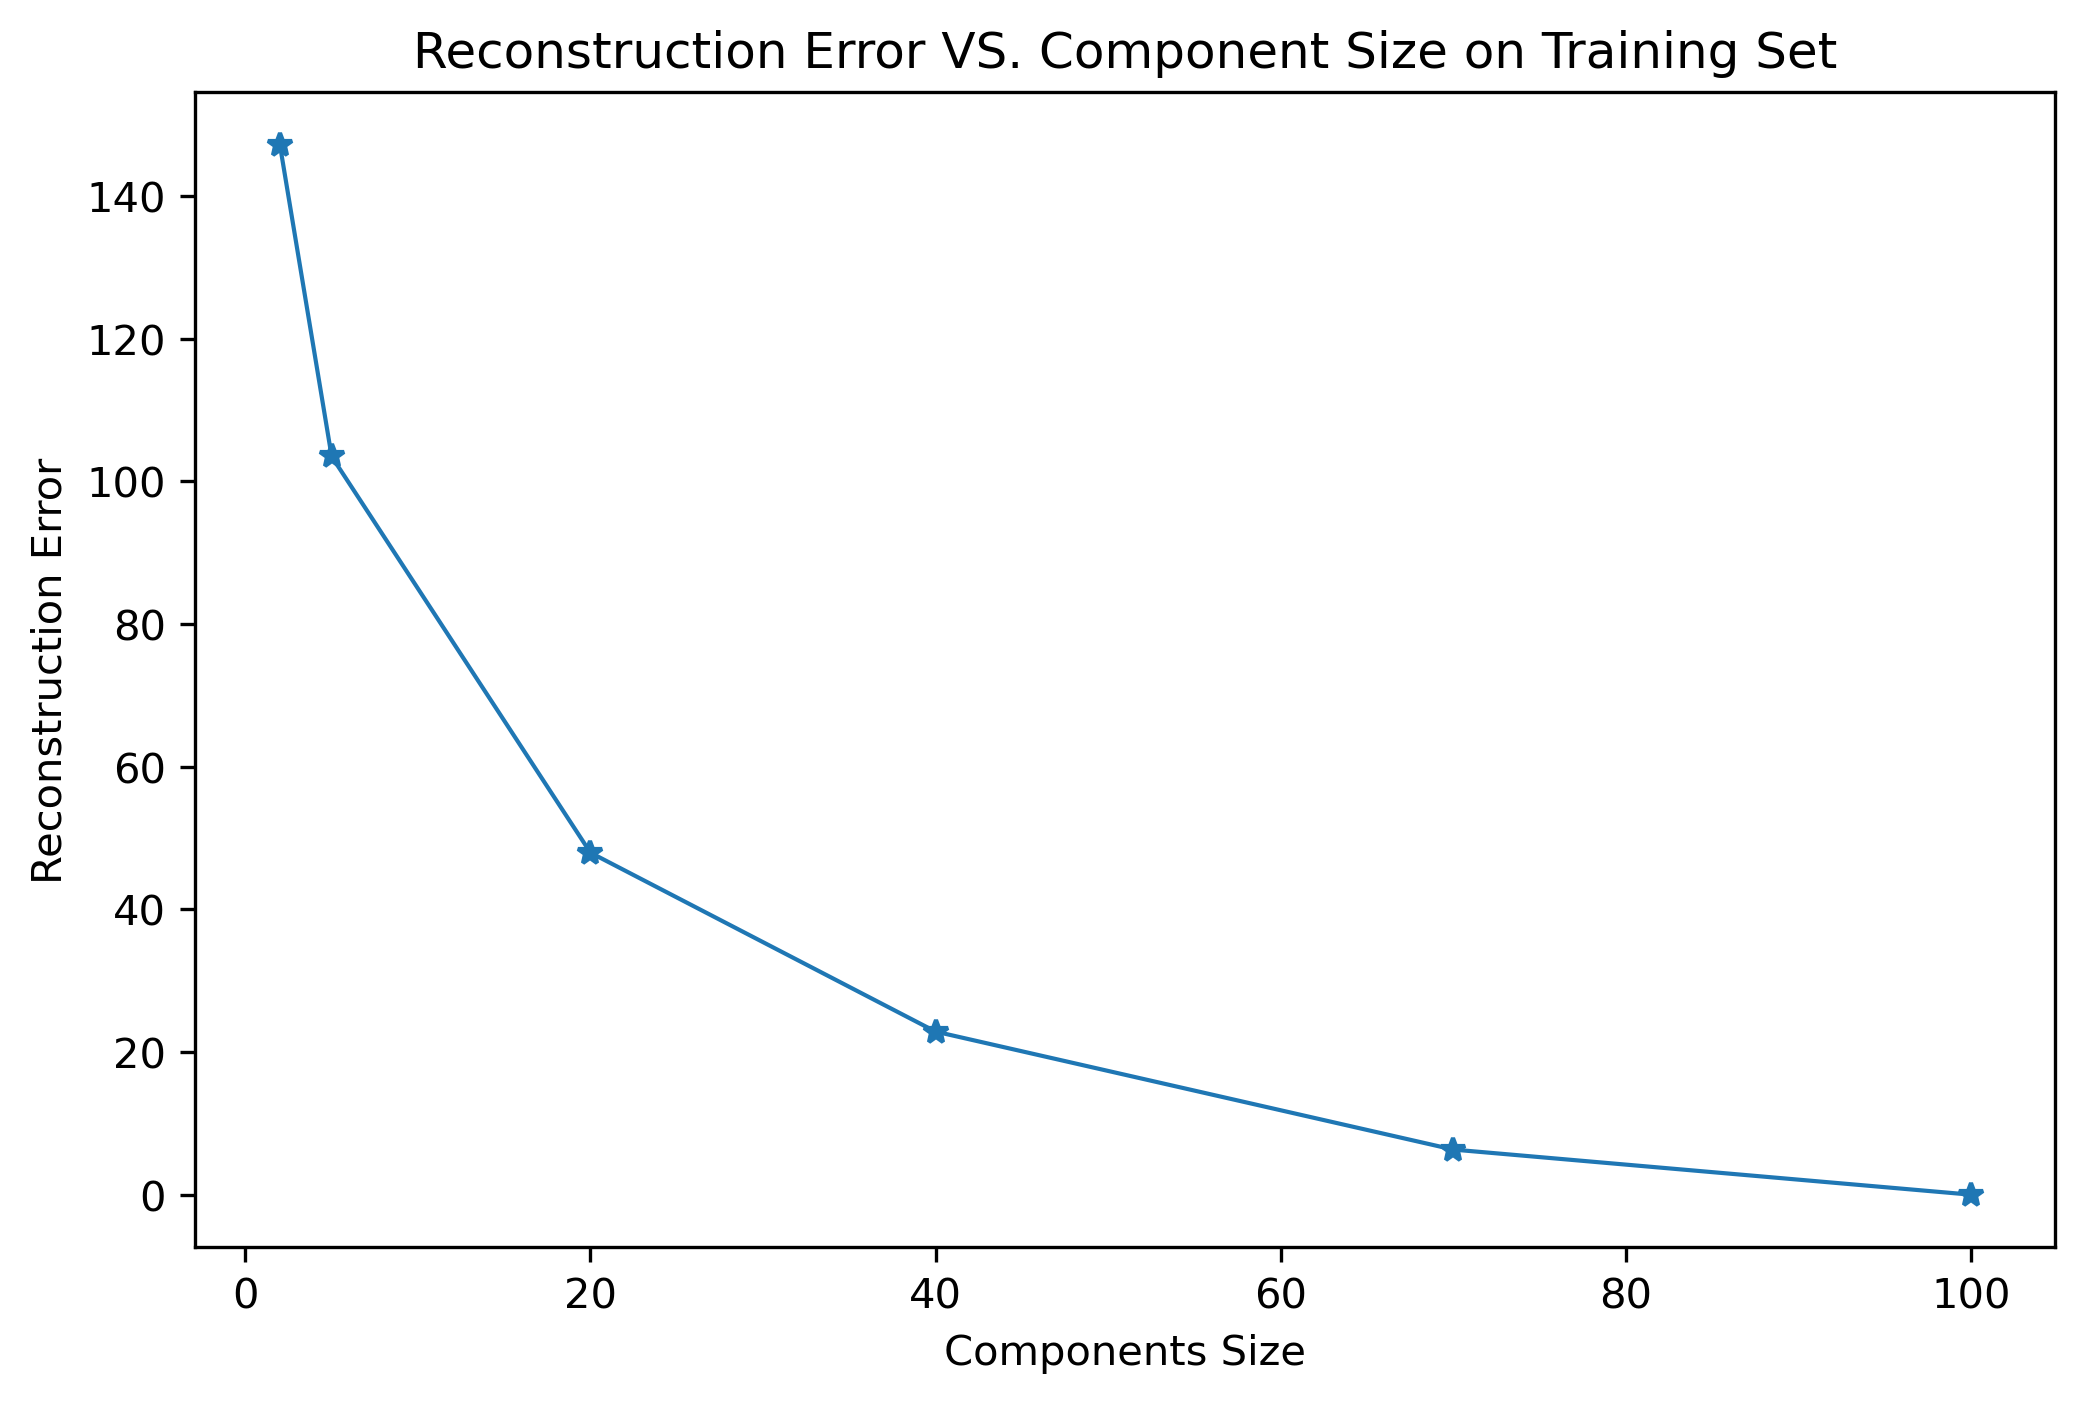

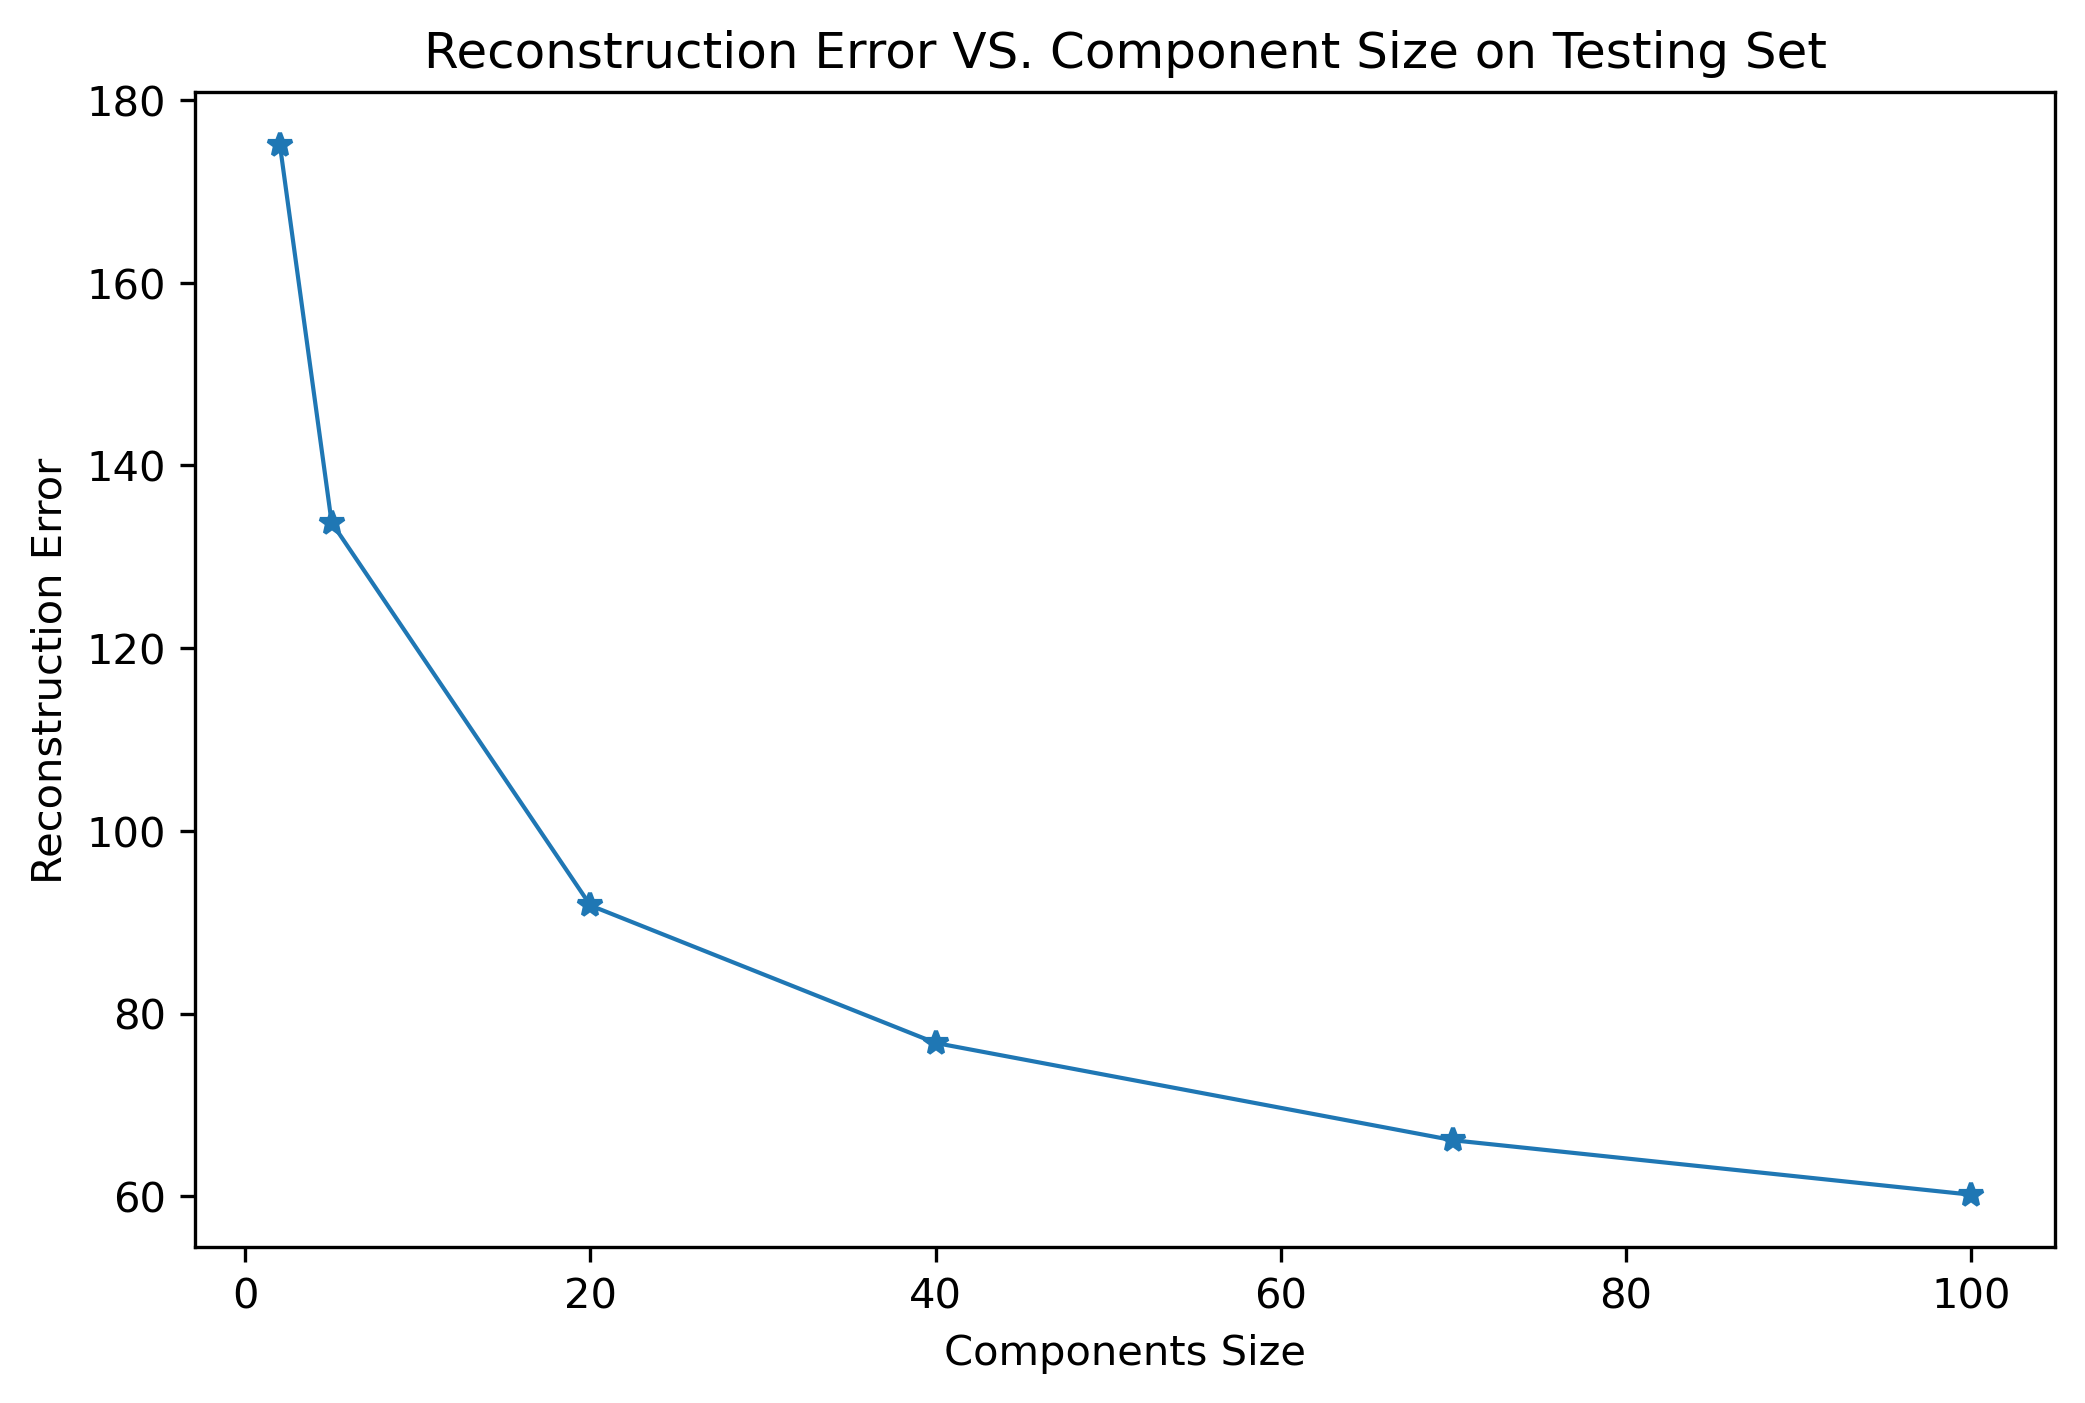

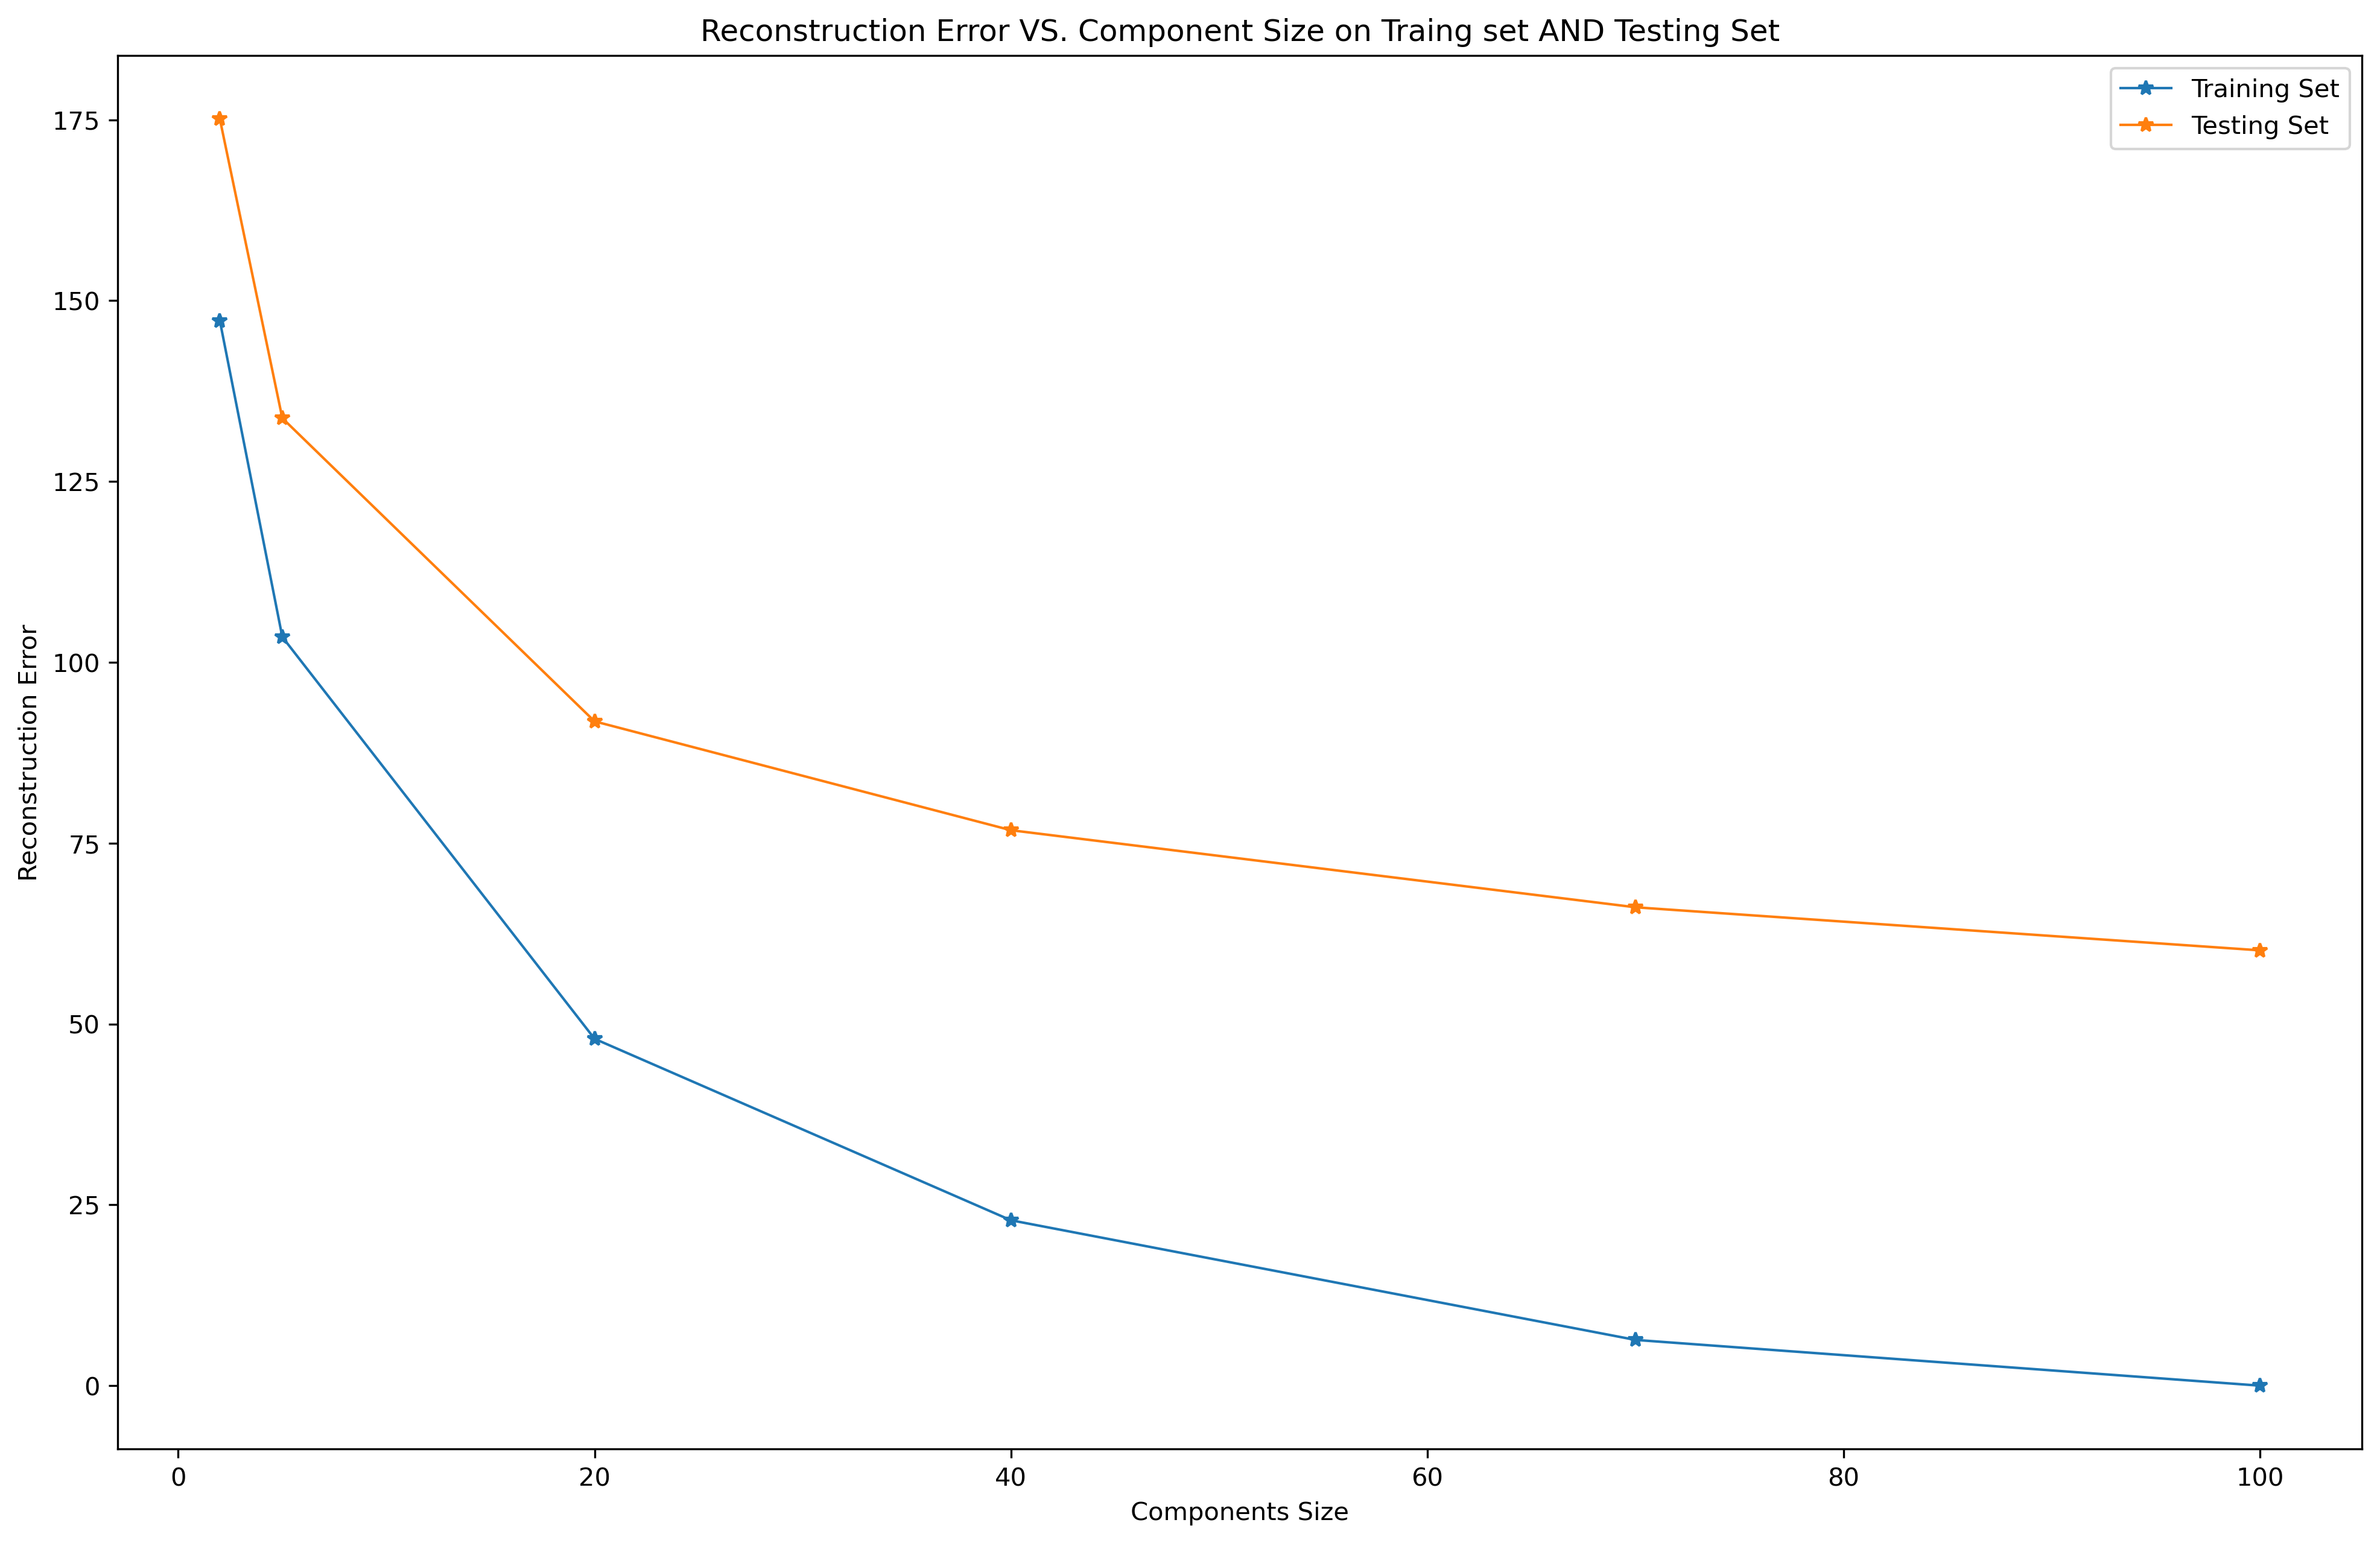

In [10]:
from matplotlib.offsetbox import TransformedBbox

# Another way to transform data
def PCATransform(XData, Vt, nComponents):
    V = np.transpose(Vt) ; XDataCOPY = np.copy(XData)
    CXDataCOPY , XDataMean = centeralize_data(XDataCOPY)
    temp = V[: , : nComponents]
    return np.matmul(CXDataCOPY , temp)

# OX : Original X
# RX : Reconstructed X
def getError(OX, RX):
    errorSum = 0 ; size = OX.shape[0]
    for i in range(size):
        p1 = OX[i , :] ; p2 = RX[i , :]
        errorSum += getSinglePointError(p1, p2)
    return errorSum / size


# helper function of getError
def getSinglePointError(p1, p2):
    error = 0
    errorArray = p1 - p2
    size = errorArray.shape[0]
    for i in range(size):
        error += (errorArray[i]) ** 2
    return error


# get Training Set and Testing Set
XCOPY = np.copy(X)
XTrain = XCOPY[:100 , :]
XTest = XCOPY[100: , :]

# SVD on training set
XTrainU , XTrainS , XTrainVt , XTrainMean = normalized_svd(XTrain)

# centralize testing set
CXTest , XTestMean = centeralize_data(XTest)

# calculate all the training set components, used for reconstruction
componentSize = [2 , 5, 20, 40, 70, 100]
XTrainComponents = []
for size in componentSize:
    XTrainComponents.append(pca_components(XTrainVt, size))


# calculate transformed data
TransformedXTrain = [] ; TransformedXTest = []
for size in componentSize:
    TransformedXTrain.append(pca_transform(XTrainU, XTrainS, size))
    TransformedXTest.append(PCATransform(XTest, XTrainVt, size))


#calculate reconstructed data
ReconstructedXTrain = [] ; ReconstructedXTest = []
for i in range(len(componentSize)):
    ReconstructedXTrain.append(pca_inverse_transform( TransformedXTrain[i] , XTrainComponents[i] , XTrainMean))
    ReconstructedXTest.append( pca_inverse_transform( TransformedXTest[i]  , XTrainComponents[i] , XTestMean))

# calcualte error
XTrainError = [] ; XTestError = []
for i in range(len(componentSize)):
    XTrainError.append(getError(XTrain , ReconstructedXTrain[i] ))
    XTestError.append(getError( XTest  , ReconstructedXTest[i] ))

# print values
print("Training Set Error = ", XTrainError)
print("Testing  Set Error = ", XTestError)

print("\n") ; print("\n")

# draw the first graph
plt.plot(componentSize, XTrainError, linewidth=1.0, marker = "*")
plt.xlabel("Components Size")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error VS. Component Size on Training Set")
plt.gcf().set_size_inches(8, 5)
plt.gcf().set_dpi(300)
plt.show()

print("\n") ; print("\n")

# draw the second graph
plt.plot(componentSize, XTestError, linewidth=1.0, marker = "*")
plt.xlabel("Components Size")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error VS. Component Size on Testing Set")
plt.gcf().set_size_inches(8, 5)
plt.gcf().set_dpi(300)
plt.show()

print("\n") ; print("\n")

# draw the second graph
plt.plot(componentSize, XTrainError, linewidth=1.0, label = "Training Set", marker = "*")
plt.plot(componentSize, XTestError, linewidth=1.0, label = "Testing Set", marker = "*")
plt.legend()
plt.xlabel("Components Size")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error VS. Component Size on Traing set AND Testing Set")
plt.gcf().set_size_inches(16, 10)
plt.gcf().set_dpi(300)
plt.show()

### **Explaine the Difference between the above two graphs**
For training set, reconstruction error decreases to 0 as component size increases to 100. However, for testing set, reconstruction error decreases to around 0.41e7 as component size increases to 100. The is the major difference between these two graphs.

When reducing dimensionality and reconstructing on both training set and testing set, eigenvectors/components used are generated from training set by SVD.  Therefore, it is easy to understand that eigenvectors/components perform better on training set. As a result, training set has less reconstruction error compared with testing set.

## Kernel PCA

### Procedure
1. Using sklearn kernel PCA as KernelPCA(kernel='rbf', n_components=100, gamma=, fit_inverse_transform=True) (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html).

2. Plot reconstruction error for train and test data in terms of gamma for gamma=[0.01, 0.05, 0.1, 0.5, 1].

### About RBF Kernel
* RBF kernel is like a Gaussian kernel. The role of the Gamma parameter is similar to the role of the inverse of the standard deviation (i.e., Gamma=1/sigma) of the Gaussian kernel. Here are some more details:

* "Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors." https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

Training Set Error =  [220.0067885844954, 194.1583622673545, 167.03418194598376, 89.19871644516843, 78.79158956011179]
Testing  Set Error =  [260.635379496344, 262.1814523771362, 272.6199193557946, 1140.6448932280177, 5676.635377774953]






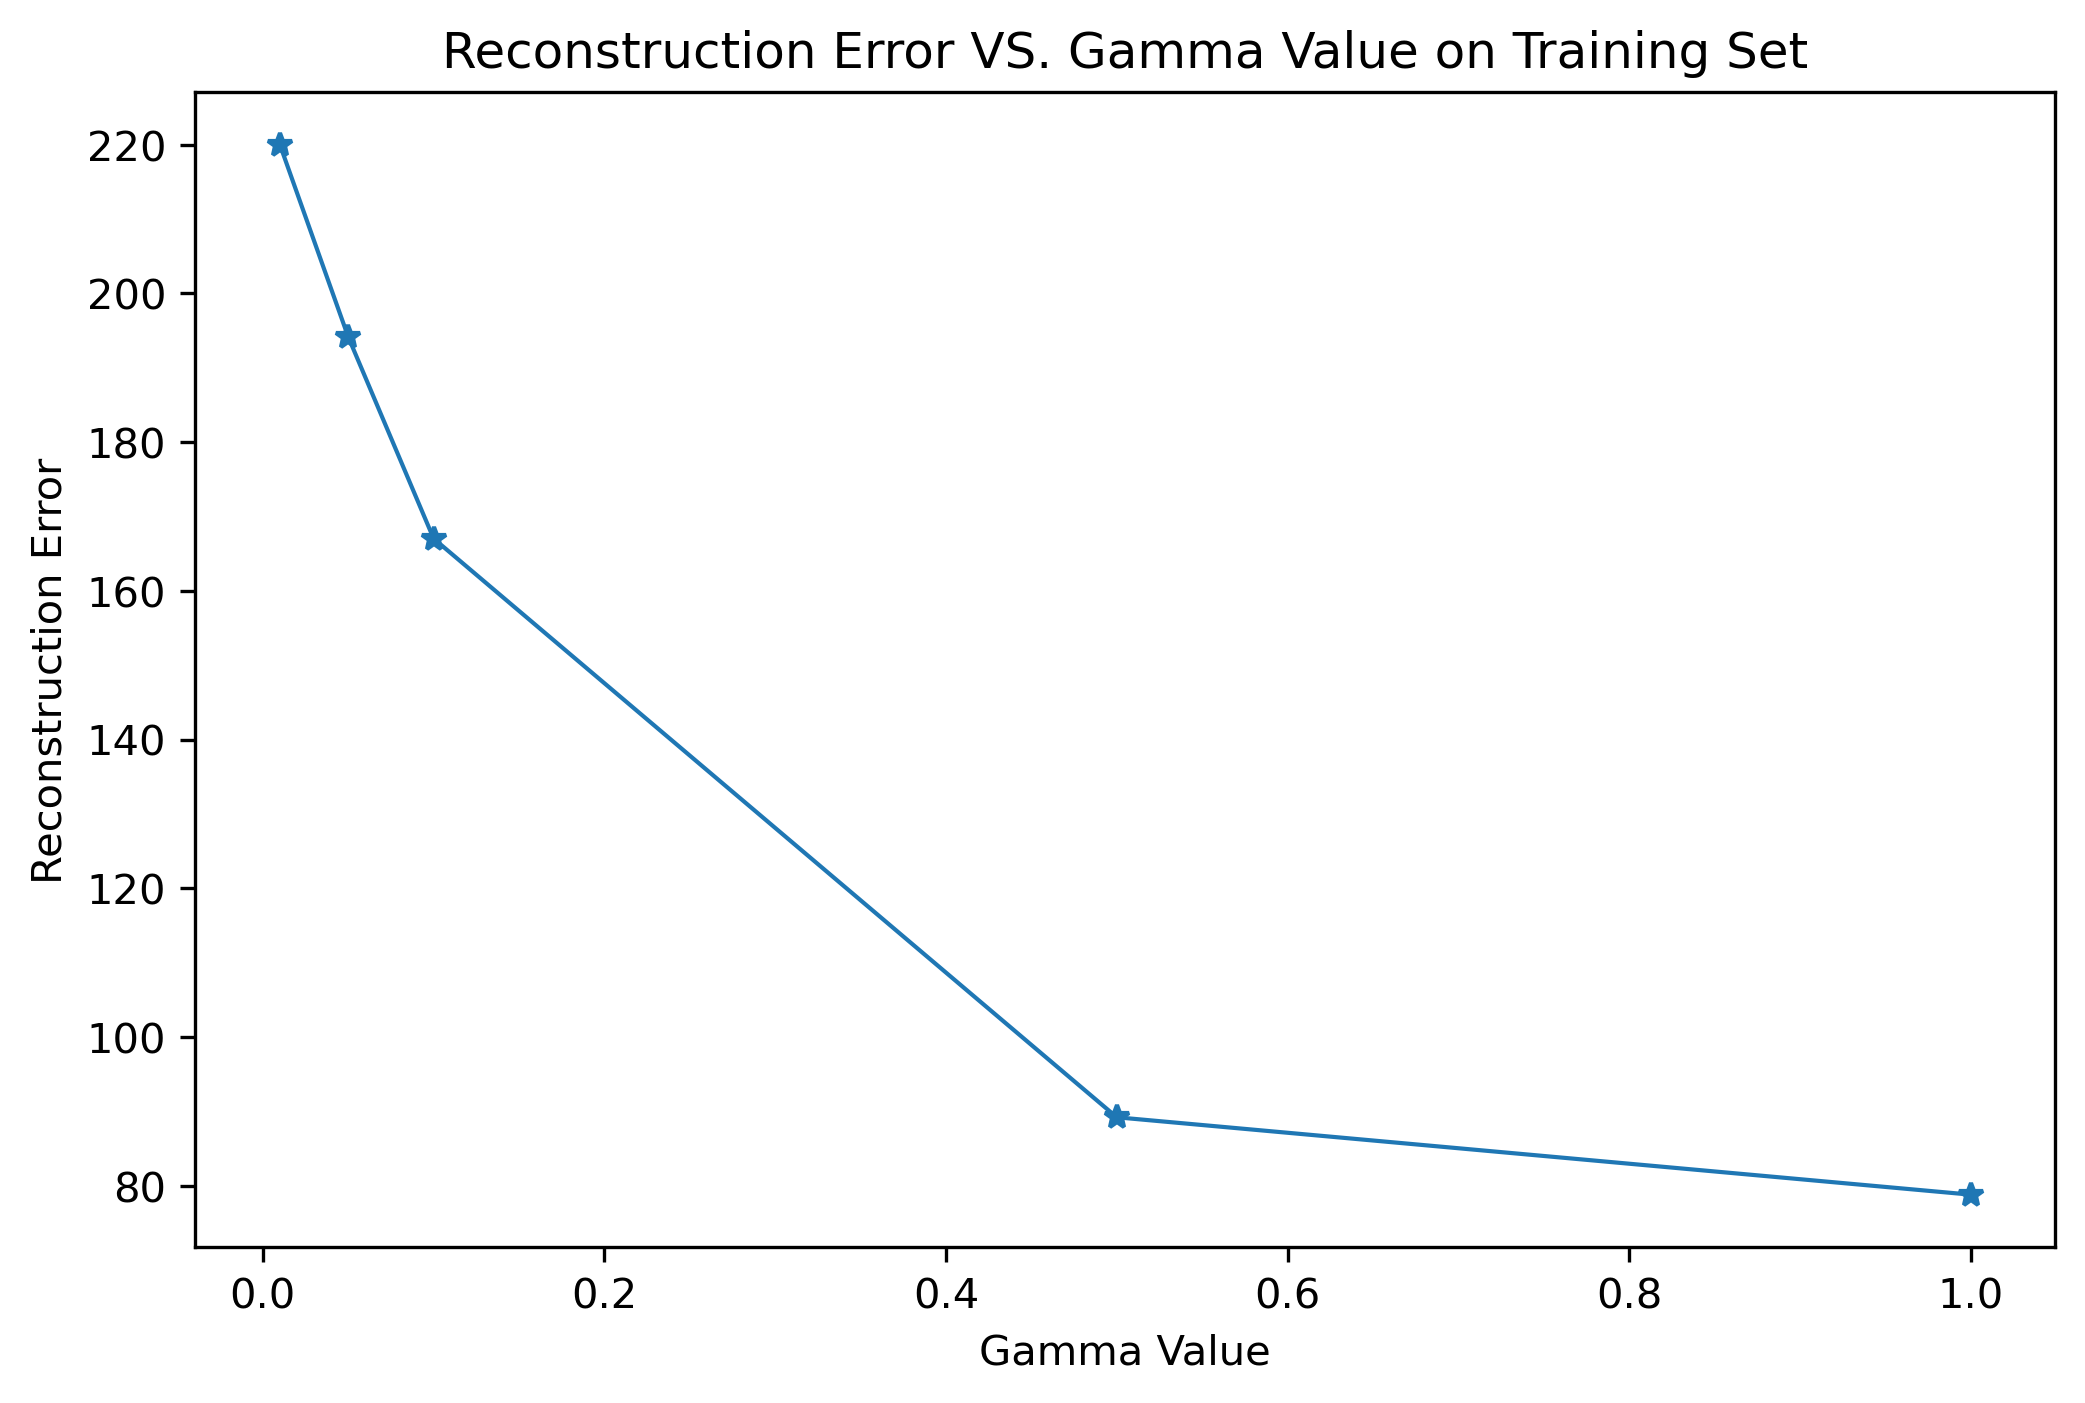

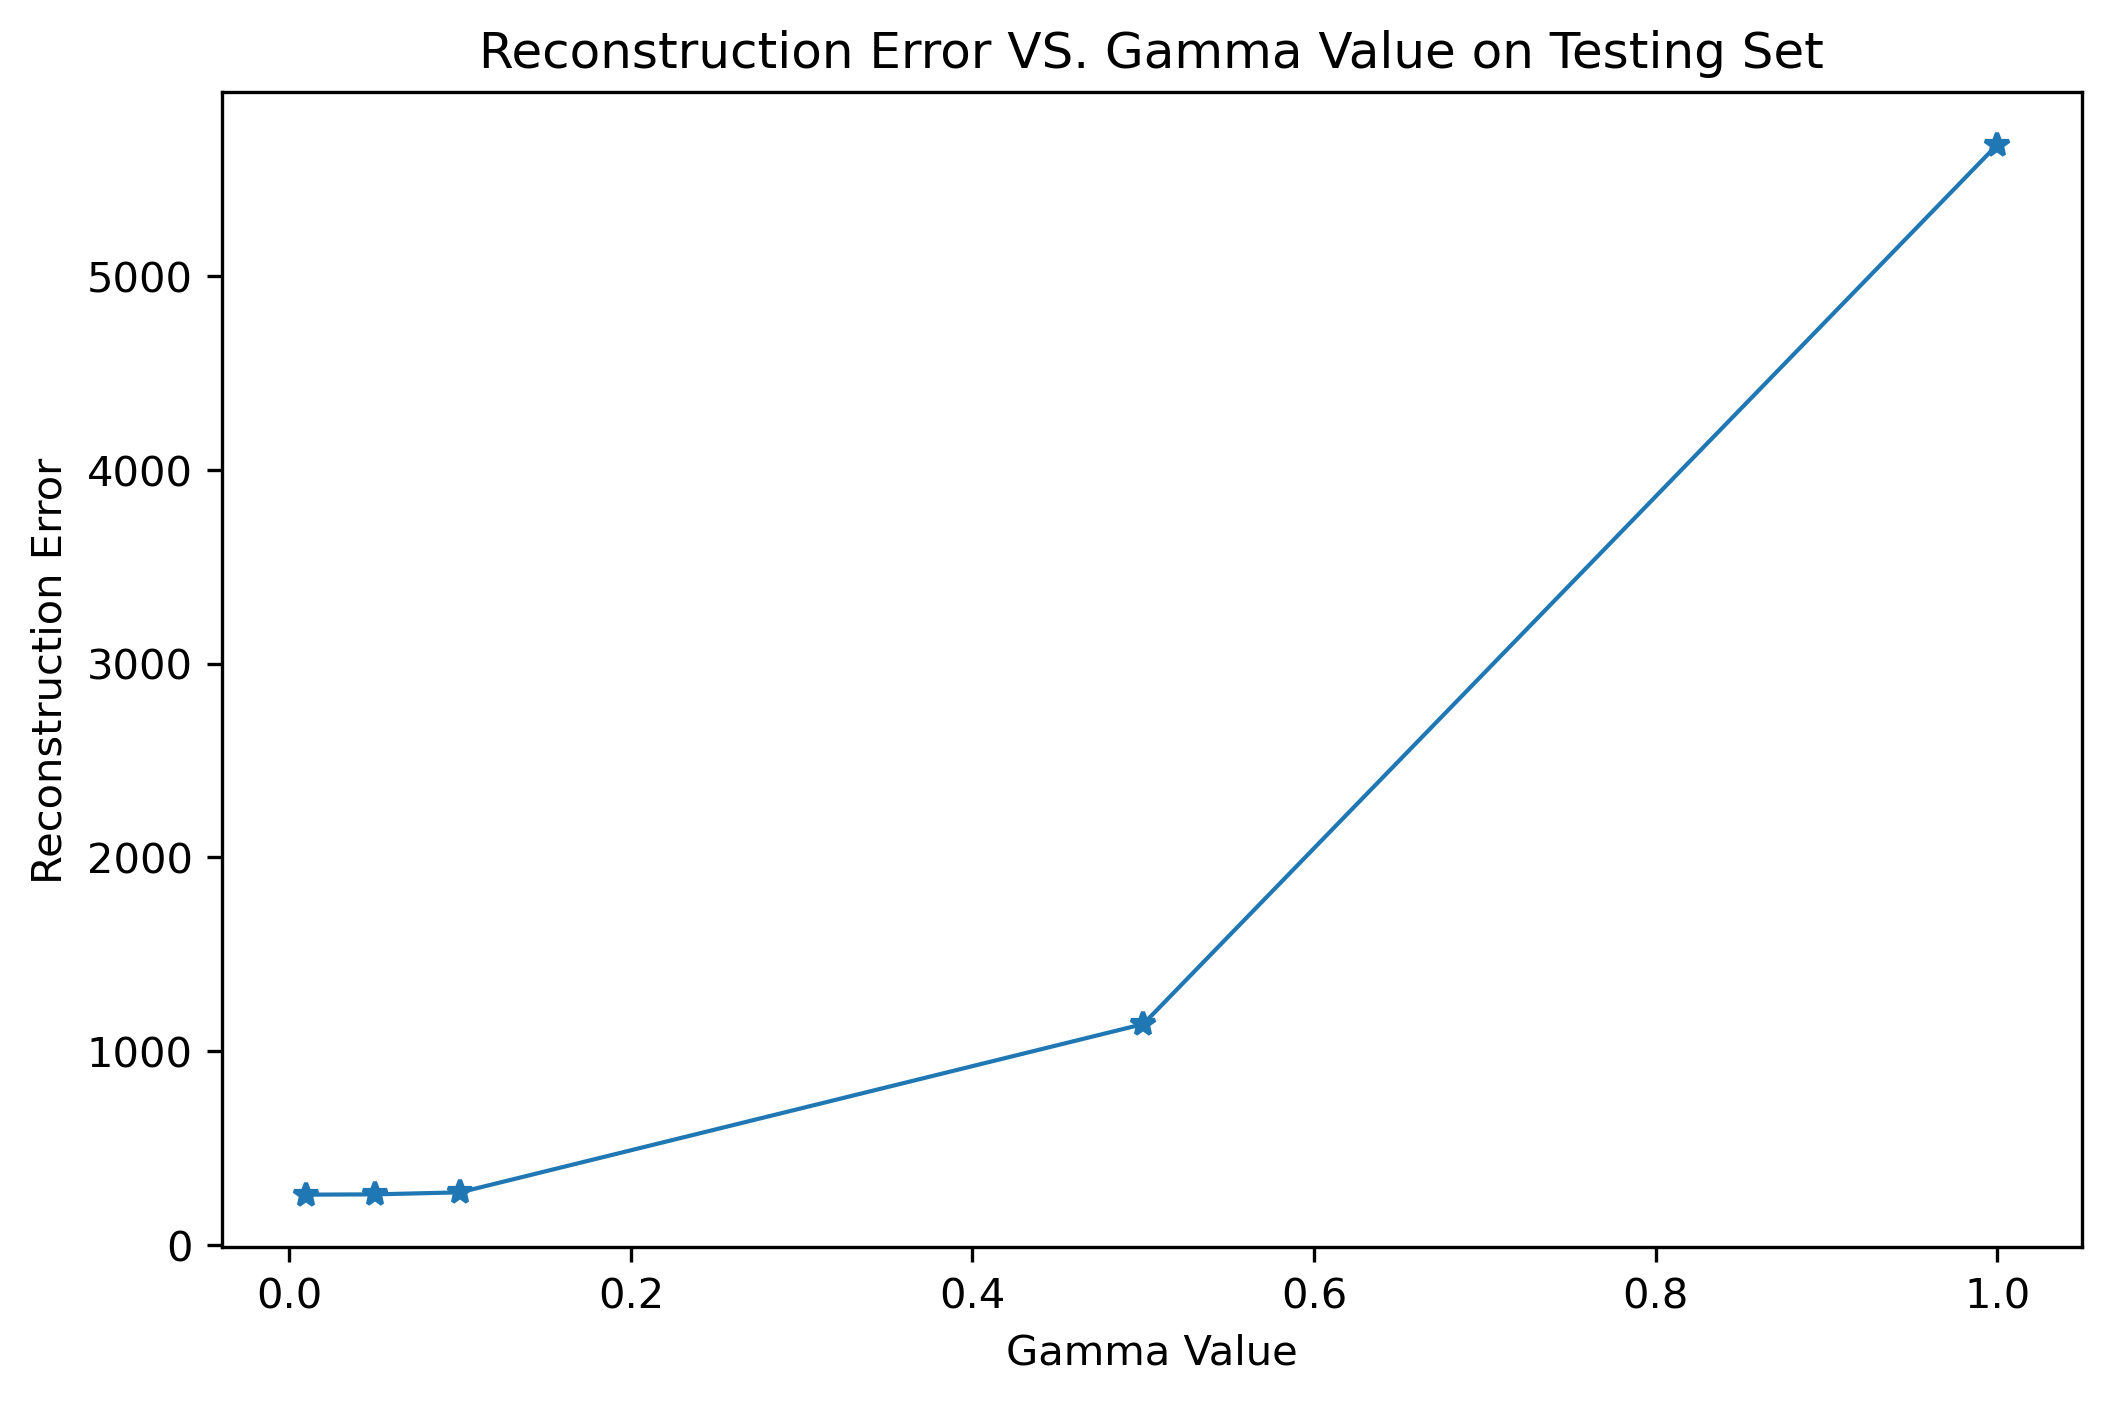

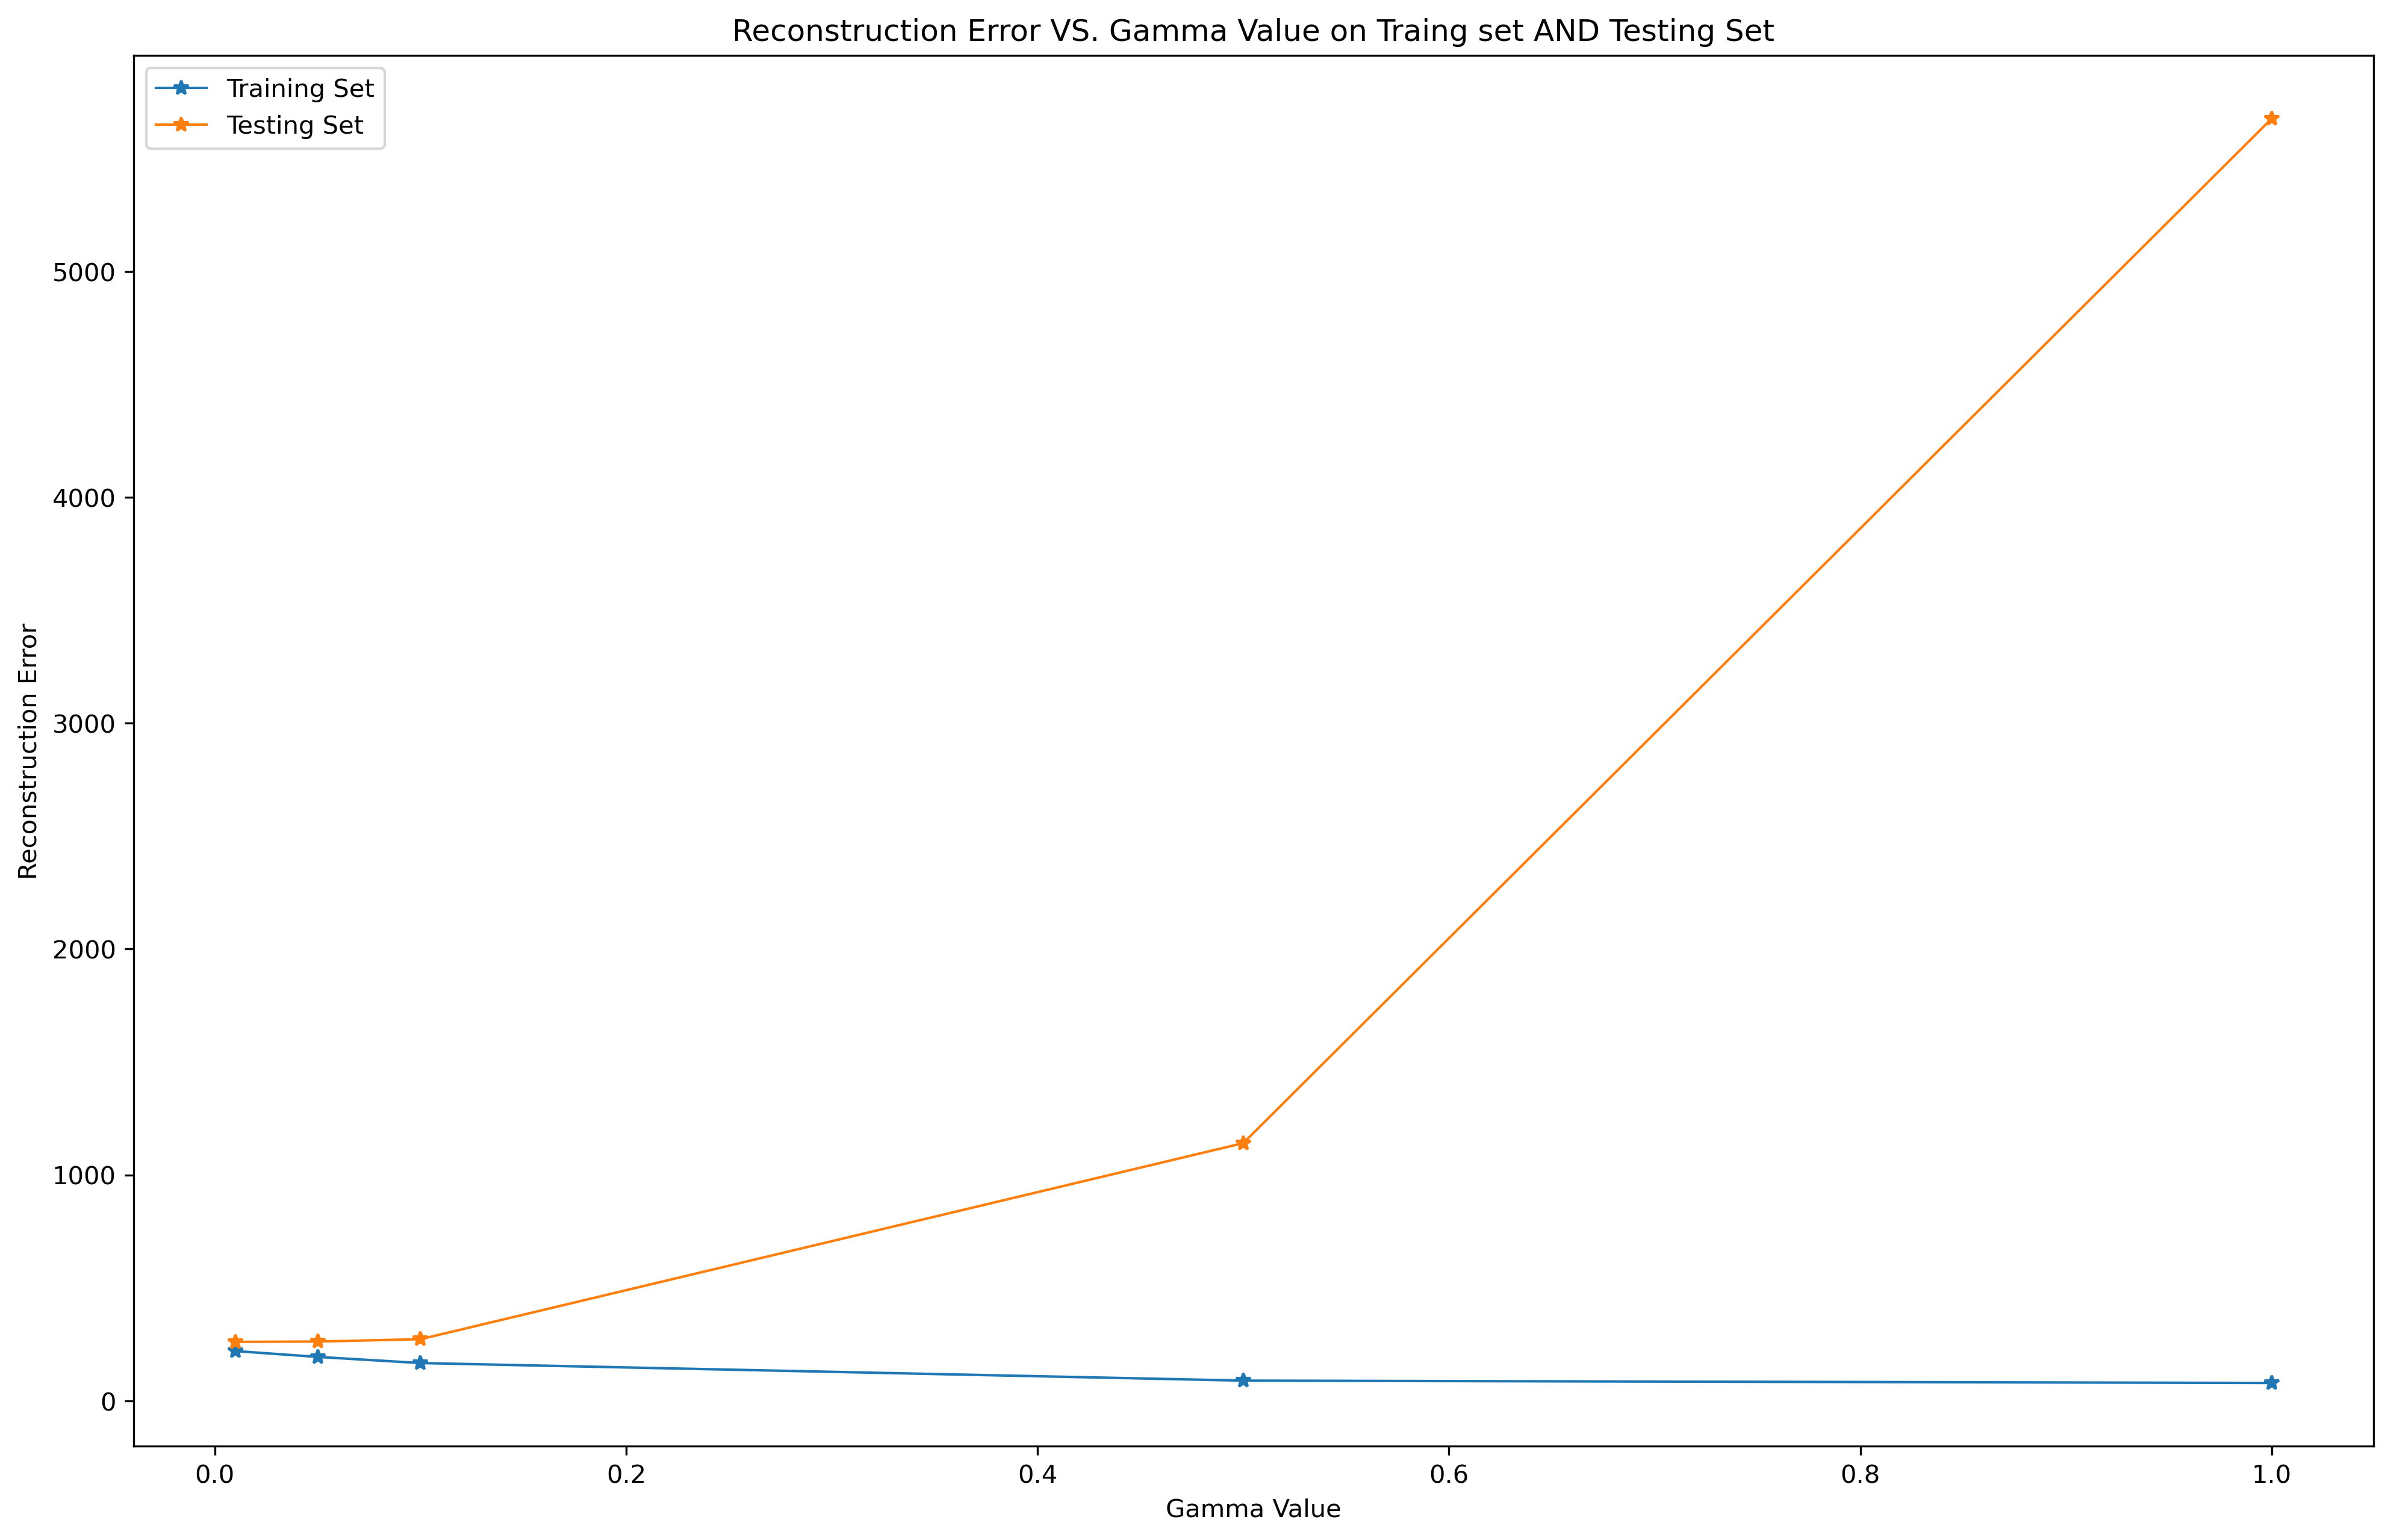

In [11]:
from matplotlib import transforms
from sklearn.decomposition import KernelPCA

# get Training Set and Testing Set
XCOPY = np.copy(X)
XTrain = XCOPY[:100 , :]
XTest = XCOPY[100: , :]

# define gamma values
gammaValues = [0.01 , 0.05 , 0.1 , 0.5 , 1]

# define components size
componentSize = 100

# initialize transformers
transformers = []
for gammaValue in gammaValues:
    transformers.append( KernelPCA(kernel='rbf', n_components=componentSize, gamma=gammaValue, fit_inverse_transform=True) )

# train the transformers
for transformer in transformers:
    transformer.fit(XTrain)

# transform data
XTrainTransformed = [] ; XTestTransformed = []
for transformer in transformers:
    XTrainTransformed.append( transformer.transform(XTrain) )
    XTestTransformed.append( transformer.transform(XTest) )


# reconstruct data
XTrainReconstructed = [] ; XTestReconstructed = []
for i in range(len(transformers)):
    XTrainReconstructed.append( transformers[i].inverse_transform(XTrainTransformed[i]) )
    XTestReconstructed.append( transformers[i].inverse_transform(XTestTransformed[i]) )

# calculate error
XTrainError = [] ; XTestError = []
for i in range(len(gammaValues)):
    XTrainError.append(getError(XTrain , XTrainReconstructed[i] ))
    XTestError.append(getError( XTest  , XTestReconstructed[i] ))


print("Training Set Error = ", XTrainError)
print("Testing  Set Error = ", XTestError)

print("\n") ; print("\n")

# draw the first graph
plt.plot(gammaValues, XTrainError, linewidth=1.0, marker = "*")
plt.xlabel("Gamma Value")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error VS. Gamma Value on Training Set")
plt.gcf().set_size_inches(8, 5)
plt.gcf().set_dpi(300)
plt.show()

print("\n") ; print("\n")

# draw the second graph
plt.plot(gammaValues, XTestError, linewidth=1.0, marker = "*")
plt.xlabel("Gamma Value")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error VS. Gamma Value on Testing Set")
plt.gcf().set_size_inches(8, 5)
plt.gcf().set_dpi(300)
plt.show()

print("\n") ; print("\n")

# draw the second graph
plt.plot(gammaValues, XTrainError, linewidth=1.0, label = "Training Set", marker = "*")
plt.plot(gammaValues, XTestError, linewidth=1.0, label = "Testing Set", marker = "*")
plt.legend()
plt.xlabel("Gamma Value")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error VS. Gamma Value on Traing set AND Testing Set")
plt.gcf().set_size_inches(16, 10)
plt.gcf().set_dpi(300)
plt.show()

### Explain the difference between two graphs
For training set, as gamma value increases, reconstruction error decreases. However, for testing set, reconstruction error increases as gamma value increases. This is the major difference between two graphs.

Larger gamma value means closer influence of training set. This implies that larger gamma could cause overfitting problem. The example provided in the link also proves this.

As a result, gamma value and reconstruction error have a negative relationship for training set since more severe overfitting problem means less error for training set. However, more severe overfitting problem means more error for testing set, this is why gamma value and reconstruction error have a positive relationship for testing set.